In [1]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns

In [2]:
def extract_features(audio_file):
    # Load the audio file using librosa
    y, sr = librosa.load(audio_file)

    # Apply pre-emphasis to the audio signal
    pre_emphasis = 0.97
    y = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

    # Extract MFCC (Mel-Frequency Cepstral Coefficients) features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    return np.mean(mfccs.T, axis=0)

In [3]:
features = []
labels = []
data_folder = 'data_set'
subfolders = ['awake', 'belly_pain', 'burping', 'discomfort', 'hug', 'hungry', 'tired']

for label, subfolder in enumerate(subfolders):
    path = os.path.join(data_folder, subfolder)
    
    if not os.path.isdir(path):
        print(f"Subfolder {path} not found.")
        continue

    for file_name in tqdm(os.listdir(path), desc=f"Processing {subfolder}"):
        if file_name.endswith('.wav'):
            audio_file = os.path.join(path, file_name)
            mfccs = extract_features(audio_file)
            features.append(mfccs)
            labels.append(label)

Processing tired: 100%|██████████| 184/184 [00:06<00:00, 30.49it/s]


In [4]:
features = np.array(features)
labels = np.array(labels)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(features, labels)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
#Create an instance of MLPClassifier
mlp = MLPClassifier(
    alpha=0.01,
    max_iter=2000,
    hidden_layer_sizes=(12,), 
    solver='lbfgs',
    random_state=1,
    early_stopping=True,
    validation_fraction=0.1
)

In [7]:
# Fit the model to the training data
mlp.fit(X_train_scaled, y_train)

# Predict labels of the test set
y_pred = mlp.predict(X_test_scaled)

In [8]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Print accuracy score
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.59      0.55       110
           1       0.97      1.00      0.99        99
           2       0.96      1.00      0.98       114
           3       0.74      0.52      0.61       119
           4       0.59      0.78      0.67       107
           5       0.68      0.59      0.63       105
           6       0.55      0.50      0.52        98

    accuracy                           0.71       752
   macro avg       0.71      0.71      0.71       752
weighted avg       0.72      0.71      0.71       752


Confusion Matrix:
 [[ 65   0   0   8  28   0   9]
 [  0  99   0   0   0   0   0]
 [  0   0 114   0   0   0   0]
 [ 19   1   1  62  11   9  16]
 [ 14   0   0   5  83   0   5]
 [ 11   1   4   7  10  62  10]
 [ 17   1   0   2   9  20  49]]
Accuracy Score:
0.7101063829787234


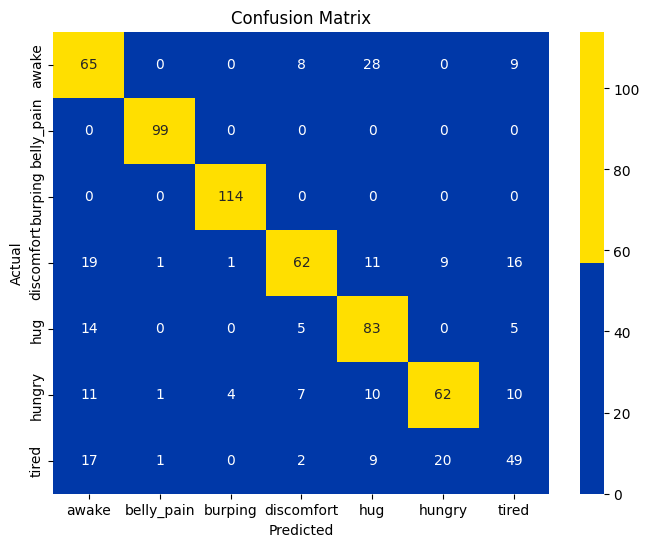

In [9]:
plt.figure(figsize=(8, 6))
yellow = (255 / 255, 223 / 255, 0 / 255)
blue = (0 / 255, 56 / 255, 168 / 255)
custom_cmap = sns.color_palette([blue, yellow])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=custom_cmap, xticklabels=subfolders, yticklabels=subfolders)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Define a function to predict the category of an audio file using the model
def predict_audio_file(file_path, model):
    try:
        # Extract MFCC features from the audio file
        mfccs = extract_features(file_path)
        
        # Reshape the MFCC features for prediction
        mfccs = mfccs.reshape(1, -1)
        
        # Make a prediction using the provided model
        prediction = model.predict(mfccs)
        
        # Print the predicted category
        print(f"File: {file_path} | Predicted category: {subfolders[prediction[0]]}")
    except Exception as e:
        print(f"Can't load file {file_path}: {e}")

# Define the path to the folder containing subfolders with audio files
folder_path = "a_p"

# Iterate through each subfolder in the main folder
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    
    # Check if the subfolder exists
    if not os.path.exists(subfolder_path):
        print(f"Subfolder {subfolder_path} not found.")
        continue

    # Print the name of the subfolder being processed
    print(f"Processing subfolder: {subfolder}")
    
    # Iterate through each audio file in the subfolder and make predictions
    for new_file in os.listdir(subfolder_path):
        file_path = os.path.join(subfolder_path, new_file)
        predict_audio_file(file_path, mlp)  # Pass the model 'knn' for prediction

Processing subfolder: awake
File: a_p\awake\awake_0.wav | Predicted category: discomfort
File: a_p\awake\awake_130.wav | Predicted category: discomfort
File: a_p\awake\awake_16.wav | Predicted category: discomfort
File: a_p\awake\awake_83.wav | Predicted category: discomfort
Processing subfolder: belly_pain
File: a_p\belly_pain\549a46d8-9c84-430e-ade8-97eae2bef787-1430130772174-1.7-m-48-bp.wav | Predicted category: discomfort
File: a_p\belly_pain\BellyPain02.wav | Predicted category: discomfort
Processing subfolder: burping
File: a_p\burping\7E4B9C14-F955-4BED-9B03-7F3096A6CBFF-1430540826-1.0-f-26-bu.wav | Predicted category: discomfort
File: a_p\burping\Burping-10.wav | Predicted category: discomfort
Processing subfolder: discomfort
File: a_p\discomfort\2294E2B2-8E36-4DA6-A898-B947CB9446AB-1436462707-1.1-m-26-dc.wav | Predicted category: discomfort
File: a_p\discomfort\Cold_Hot09.wav | Predicted category: discomfort
File: a_p\discomfort\diaper_6.wav | Predicted category: discomfort
Fi